In [2]:
pip install transformers -U

  Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1
You should consider upgrading via the '/cafe/u/shrutive/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import transformers
print(transformers.__version__)

/cafe/u/shrutive/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.41.2


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# from collections.abc import Sequence
from typing import Sequence
import torch
import numpy as np
import time

_SSM_NAME = "JackFram/llama-160m"
_LLM_NAME = 'openlm-research/open_llama_3b_v2'
device = "cuda"

assert torch.cuda.is_available()
tokenizer = AutoTokenizer.from_pretrained(_SSM_NAME)
ssm = AutoModelForCausalLM.from_pretrained(_SSM_NAME, device_map='auto')
llm = AutoModelForCausalLM.from_pretrained(_LLM_NAME, device_map='auto')


/cafe/u/shrutive/myenv/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [3]:
def _create_token_tree(
    expansion_config: Sequence[int],
    prompt: str,
    tokenizer: AutoTokenizer,
    model: AutoModelForCausalLM,
    has_kv_cache: bool = False,
):
    """Create token tree following Figure 3 in the paper.

    We don't need "real" tokens for our experiments - just
    random integers would work too - but might as well.

    Figure 3 illustrates the <k1, k2, ...> expansion approach they
    use to create token trees. We can use each of the top_k tokens from
    a single model to create the same tree structure.

    Args:
        expansion_config: A sequence of integers representing how much to
            branch at each generation step.
        prompt: Initial prompt.
        tokenizer: HF tokenizer.
        model: HF generative model.
    """
    assert expansion_config
    current_tree = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
    if has_kv_cache:
        assert tokenizer.add_bos_token
        current_tree = current_tree[:, 1:]
    for k in expansion_config:
        output = model.generate(
            current_tree,
            max_new_tokens=1,
            return_dict_in_generate=True,
            output_scores=True,
        )
        # Take the top_k tokens from the 1 generation step we've done
        top_k = torch.topk(output.scores[-1], k=k, dim=-1).indices.reshape(-1, 1)
        current_tree = torch.repeat_interleave(current_tree, k, dim=0)
        # Join the top_k tokens to the current tree
        current_tree = torch.cat((current_tree, top_k), dim=-1)

    return current_tree

In [4]:
def _invert_4d_attention_mask(attention_mask: torch.Tensor, kv_cache_num_tokens: int=0) -> torch.Tensor:
    """For 4D masks, new HF requires us to invert the mask so it doesn't modify it at all."""
    # The attention mask must have last 2 dims shape [current seq len, KV cache size + current seq len]
    # So we prepend a tensor of 1s to allow attending to the full KV cache
    assert attention_mask.dim() == 4
    if kv_cache_num_tokens > 0:
        attention_mask = torch.cat(
            (
                torch.ones(
                    attention_mask.shape[0],
                    attention_mask.shape[1],
                    attention_mask.shape[2],
                    kv_cache_num_tokens,
                ).to(device),
                attention_mask,
            ),
            dim=-1,
        )
    # Invert the mask: 0s to -inf and 1s to 0 (0 means attention allowed)
    min_dtype = torch.finfo(torch.float32).min
    min_dtype = -1e+30 if attention_mask.dtype == torch.float32 else -1e+4
    attention_mask.masked_fill_(attention_mask == 0.0, min_dtype)
    attention_mask.masked_fill_(attention_mask == 1, 0.0)
    return attention_mask

def construct_tree_model_inputs(sequences):
    # input_1 = torch.unique(torch.flatten(sequences), sorted=False)
    flat = torch.flatten(sequences).tolist()
    unique = []
    for tok in flat:
        if tok not in unique:
            unique.append(tok)
    # input is list of unique tokens
    input_1 = torch.tensor([unique]).to(device)

    a = input_1.shape[-1]
    mask_1 = np.zeros((a, a))
    positions = [-1] * len(unique)
    
    for seq in sequences:
        branch_progress = []
        for (pos, tok) in enumerate(seq):
            input_1_idx = unique.index(tok)
            positions[input_1_idx] = pos
            branch_progress.append(input_1_idx)
            for idx in branch_progress:
                mask_1[input_1_idx][idx] = 1
    mask_1 = torch.tensor(mask_1, device=device, dtype=torch.int64)
    mask_1 = mask_1.unsqueeze(0).unsqueeze(0).to(device).int()
    position_ids_1 = torch.tensor([positions], device=device, dtype=torch.int64)
    return (input_1, mask_1, position_ids_1)

In [5]:
def _create_dummy_kv_cache(
    kv_cache_num_tokens: int,
    batch_size: int,
    num_attention_heads: int,
    hidden_size: int,
    num_layers: int,
):
    k = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    v = torch.rand(
        batch_size,
        num_attention_heads,
        kv_cache_num_tokens,
        hidden_size // num_attention_heads,
    ).to(device)
    return tuple((k, v) for _ in range(num_layers))

In [6]:
def time_normal(input_ids, model: AutoModelForCausalLM):
    with torch.inference_mode():
        model(input_ids=input_ids)

def time_tree(input_ids, mask, position_ids, model: AutoModelForCausalLM):
    with torch.inference_mode():
        model(input_ids=input_ids, attention_mask=mask, position_ids=position_ids)

In [7]:
from torch.profiler import profile, ProfilerActivity, schedule

# Guide: https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html

_N_ITERATIONS = 10
_WAIT_STEPS = 1
_WARMUP_STEPS = 1
schedule_params = {
    'wait': _WAIT_STEPS,
    'warmup': _WARMUP_STEPS,
    'active': _N_ITERATIONS - _WAIT_STEPS - _WARMUP_STEPS,
}
profiler_kwargs = {
    'activities': [ProfilerActivity.CPU, ProfilerActivity.CUDA],
    'profile_memory': True,
    'schedule': schedule(**schedule_params),
    'record_shapes': True
}

def print_normal_profile_stats(input, model):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        for _ in range(_N_ITERATIONS):
            model(input_ids=input, past_key_values = torch.tensor([3, 5, 7]), use_cache = True)
            prof.step()
    print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

def print_tree_profile_stats(input, mask, position_ids, model):
    with torch.inference_mode(), profile(**profiler_kwargs) as prof:
        for _ in range(_N_ITERATIONS):
            model(input_ids=input, attention_mask=mask, position_ids=position_ids, past_key_values = torch.tensor([1, 2, 3]), use_cache = True)
            prof.step()
    print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [8]:
def find_factors(n):    
    return [[i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0]

In [9]:
import itertools 
def generate_expansion_configs(config_length, min_expansion, max_expansion):
    values = [i for i in range(min_expansion, max_expansion)]
    result = list(itertools.product(values, repeat=config_length))
    return result

In [17]:
# NEW: 
import torch.utils.benchmark as benchmark
import matplotlib.pyplot as plt
import numpy as np

N_ITERATIONS = 32

#tree_lengths = range(1, 10)
# B = range(2, 10)
# sequential_times = []
# tree_times = []

expansion_configs = generate_expansion_configs(3, 2, 8) # first arg = length of config, second arg = min val in config, third = max
kv_sizes = [0, 128, 256, 512, 1024, 2048]
# expansion_configs = [(7, 7, 7)]
# kv_sizes = [1024]

# past_key_values, need tuple of two tensors of shape (batch_size, num_heads, sequence_length, embed_size_per_head))
sequential_times = {}
tree_times = {}

for config in expansion_configs: 
    for kv_size in kv_sizes:
        print("-----------")
        overall_conf = str(config) + ", " + str(kv_size)
        print(overall_conf)
        token_tree = _create_token_tree(
                expansion_config=config,
                prompt="The",
                tokenizer=tokenizer,
                model=ssm,
            )

        batch_size=np.prod(config)
        kv_cache_sequential = _create_dummy_kv_cache(
            kv_cache_num_tokens=kv_size,
            batch_size=batch_size,
            num_attention_heads=llm.config.num_attention_heads,
            hidden_size=llm.config.hidden_size,
            num_layers=llm.config.num_hidden_layers
        )
        
        sequential_timer = benchmark.Timer(
            stmt="time_normal(input_ids, model)",
            setup="from __main__ import time_normal",
            num_threads=torch.get_num_threads(),
            globals={
                'input_ids': token_tree,
                'model': llm,
                'kv_cache': kv_cache_sequential
            },
            label="Sequential"
        )
        sequential_measurement = sequential_timer.timeit(N_ITERATIONS)
        seq_time = sequential_measurement.times[-1]
        sequential_times[overall_conf] = seq_time
        print("Sequential Time: ", seq_time)
        
        # construct inputs for tree decoding
        kv_cache_tree = _create_dummy_kv_cache(
            kv_cache_num_tokens=kv_size,
            batch_size=1,
            num_attention_heads=llm.config.num_attention_heads,
            hidden_size=llm.config.hidden_size,
            num_layers=llm.config.num_hidden_layers
        )
        tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
        # Required for 4D mask support in new HF
        tree_mask = _invert_4d_attention_mask(tree_mask, kv_size)
        tree_timer = benchmark.Timer(
            stmt="time_tree(input_ids, mask, position_ids, model)",
            setup="from __main__ import time_tree",
            num_threads=torch.get_num_threads(),
            globals={
                'input_ids': tree_input,
                'mask': tree_mask,
                'position_ids': tree_position_ids,
                'model': llm,
                'kv_cache': kv_cache_tree
            },
            label="Tree"
        )
        token_tree = token_tree.cpu()
        tree_input = tree_input.cpu()
        tree_mask = tree_mask.cpu()
        tree_position_ids = tree_position_ids.cpu()
        tree_measurement = tree_timer.timeit(N_ITERATIONS)
        tree_time = tree_measurement.times[-1]
        tree_times[overall_conf] = tree_time
        print("Tree Time: ", tree_time)
        print("-----------")

-----------
(2, 2, 2), 0
Sequential Time:  0.07214655948337168
Tree Time:  0.03981226298492402
-----------
-----------
(2, 2, 2), 128
Sequential Time:  0.07203928218223155
Tree Time:  0.039799969643354416
-----------
-----------
(2, 2, 2), 256
Sequential Time:  0.07204580714460462
Tree Time:  0.03979276749305427
-----------
-----------
(2, 2, 2), 512
Sequential Time:  0.07203923910856247
Tree Time:  0.03983791545033455
-----------
-----------
(2, 2, 2), 1024
Sequential Time:  0.0720571915153414
Tree Time:  0.03987861319910735
-----------
-----------
(2, 2, 2), 2048
Sequential Time:  0.07208873436320573
Tree Time:  0.03985221148468554
-----------
-----------
(2, 2, 3), 0
Sequential Time:  0.07398299698252231
Tree Time:  0.04084786877501756
-----------
-----------
(2, 2, 3), 128
Sequential Time:  0.07402023312170058
Tree Time:  0.04078805272001773
-----------
-----------
(2, 2, 3), 256
Sequential Time:  0.07401675870642066
Tree Time:  0.04084043705370277
-----------
-----------
(2, 2, 3)

OutOfMemoryError: CUDA out of memory. Tried to allocate 700.00 MiB (GPU 0; 23.65 GiB total capacity; 21.64 GiB already allocated; 585.44 MiB free; 22.21 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
sequential_times[(2, 2, 3)]
tree_times[(2, 2, 3)]

In [ ]:
# OLD
import torch.utils.benchmark as benchmark

N_ITERATIONS = 32

tree_lengths = range(1, 10)
sequential_times = []
tree_times = []

for tree_length in tree_lengths:
    config = [2 for i in range(tree_length + 1)]
    token_tree = _create_token_tree(
        expansion_config=config,
        prompt="The",
        tokenizer=tokenizer,
        model=ssm,
    )
    print(token_tree)
    
    sequential_timer = benchmark.Timer(
        stmt="time_normal(input_ids, model)",
        setup="from __main__ import time_normal",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': token_tree,
            'model': llm
        },
        label="Sequential"
    )
    sequential_measurement = sequential_timer.timeit(N_ITERATIONS)
    sequential_times.append(sequential_measurement.times[-1])
    
    # construct inputs for tree decoding
    tree_input, tree_mask, tree_position_ids = construct_tree_model_inputs(token_tree)
    print(tree_input, tree_mask, tree_position_ids)

    tree_timer = benchmark.Timer(
        stmt="time_tree(input_ids, mask, position_ids, model)",
        setup="from __main__ import time_tree",
        num_threads=torch.get_num_threads(),
        globals={
            'input_ids': tree_input,
            'mask': tree_mask,
            'position_ids': tree_position_ids,
            'model': llm
        },
        label="Tree"
    )
    tree_measurement = tree_timer.timeit(N_ITERATIONS)
    tree_times.append(tree_measurement.times[-1])
    
    # print_normal_profile_stats(token_tree, llm)
    # print_tree_profile_stats(tree_input, tree_mask, tree_position_ids, llm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

width = 0.35
plt.figure(figsize=(10, 10))

x_data = tree_widths
y_sequential = np.array(sequential_times) * 1000 # scale to ms
plt.bar(x_data, y_sequential, label="Sequential", width=width)  # Plot the first list as the y-axis values
y_tree = np.array(tree_times) * 1000 # scale to ms
plt.bar([pos + width for pos in x_data], y_tree, label="Tree", width=width)  # Plot the second list as the y-axis values

plt.xlabel("Tree Length")
plt.ylabel("Latency (ms)")
plt.legend()

plt.show()
plt.savefig("tree_vs_sequential.png")

In [ ]:
!pip install matplotlib

In [61]:
import itertools
import metrics
import numpy as np
import torch
from transformers import AutoConfig

config = AutoConfig.from_pretrained("openlm-research/open_llama_3b_v2")

_PROMPT_LENGTH = 0
gpu = metrics.A6000

def is_small_and_monotonic_decreasing(arr):
    arr = np.array(arr)
    return np.prod(arr) <= 64 and np.all(arr[:-1] >= arr[1:])

def generate_expansion_configs():
    k_1_values = np.array([4, 8, 16])
    k_2_values = np.array([1])
    remaining_k_i_values = np.array([1])
    all_configs = []
    for length in [4, 8]:
        all_configs.extend(
            list(
                itertools.product(
                    k_1_values,
                    k_2_values,
                    *[remaining_k_i_values for _ in range(length - 2)],
                )
            )
        )
    return list(filter(is_small_and_monotonic_decreasing, all_configs))


kv_cache_sizes = [0, 4, 32]
results = np.zeros((len(kv_cache_sizes), len(generate_expansion_configs())))
for i, expansion_config in enumerate(generate_expansion_configs()):
    for j, kv_cache_size in enumerate(kv_cache_sizes):
        to_add = _PROMPT_LENGTH if kv_cache_size == 0 else 0
        sequential = metrics.get_gpu_latency(
            gpu=gpu,
            token_batch=torch.ones(np.prod(expansion_config), to_add + len(expansion_config)),
            dtype=torch.float16,
            num_layers=config.num_hidden_layers,
            d_model=config.hidden_size,
            n_head=config.num_attention_heads,
            vocab_size=config.vocab_size,
            kv_cache_token_count=kv_cache_size  
        )
        tree = metrics.get_gpu_latency(
            gpu=gpu,
            token_batch=torch.ones(1, to_add + np.sum(np.cumprod(expansion_config))),
            dtype=torch.float16,
            num_layers=config.num_hidden_layers,
            d_model=config.hidden_size,
            n_head=config.num_attention_heads,
            vocab_size=config.vocab_size,
            kv_cache_token_count=kv_cache_size
        )
        results[j, i] = (sequential - tree) * 1000



/nlp/scr/ananthag/miniconda3/envs/spec/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<Figure size 2400x800 with 0 Axes>

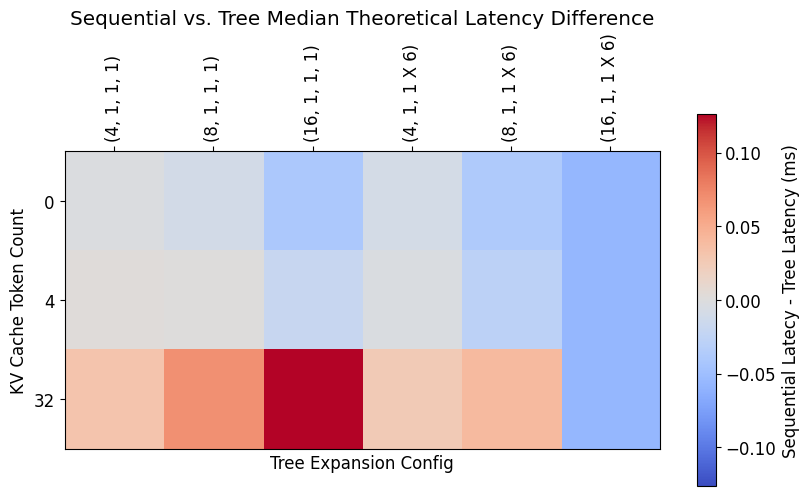

In [64]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(24, 8))
max_abs_value = np.max(np.abs(results))
cax = plt.matshow(results, cmap='coolwarm', clim=(-max_abs_value, max_abs_value))
# Add a colorbar to indicate the scale
plt.colorbar(cax, label='Sequential Latecy - Tree Latency (ms)')
plt.gca().xaxis.tick_top()
x_labels = []
for config in generate_expansion_configs():
    if len(config) < 8:
        x_labels.append(str(config))
    else:
        new_label = "(" + str(config[0]) + ", 1, 1 X " + str(len(config) - 2) + ")"
        x_labels.append(new_label)
plt.xticks(range(len(generate_expansion_configs())), x_labels, rotation=90)
plt.yticks(range(len(kv_cache_sizes)), kv_cache_sizes)
plt.xlabel("Tree Expansion Config")
plt.ylabel("KV Cache Token Count")
plt.title('Sequential vs. Tree Median Theoretical Latency Difference')
plt.savefig(f'theoretical_latencies.png', format='png', dpi=300, bbox_inches='tight')
plt.show()